In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from collections import Counter
from prettytable import PrettyTable

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Suicide_Detection/reddit_suicide_detection_final_clean.csv', header=0)

In [4]:
df.drop(columns=['text'], axis=1, inplace=True)
df = df.rename(columns={"cleaned_text": "text"})
classes = {"suicide": 1, "non-suicide": 0}
df = df.replace({"class": classes})
df = df[df['text'].notnull()]
df

,class,text
0,1,sex wife threaten suicide recently leave wife ...
1,0,weird not affect compliment come know girl but...
2,0,finally never hear bad year swear fucking god ...
3,1,need help help cry hard
4,1,end tonight not anymore quit
...,...,...
174170,0,today went sled friend not like but pretty big...
174171,0,not like rock not go but
174172,0,tell friend not lonely deprive buy little nigh...
174173,0,pee probably taste like salty tea drink pee co...


### Split dataset into training, validation and test sets

In [5]:
train_text, test_text, train_labels, test_labels = train_test_split(df['text'], df['class'],
                                                                    random_state= 0,
                                                                    test_size=0.2,
                                                                    stratify=df['class'])

### Import Vocab

In [6]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load the vocabulary
vocab_filename = '/content/gdrive/MyDrive/Suicide_Detection/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

### Import Embeddings

In [7]:
# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()[1:]
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
	return embedding

### Removing Out-of-vocab words

In [8]:
# clean each line
def clean_line(line, vocab):
  tokens = line.split()
  # filter out tokens not in vocab
  tokens_clean = [w for w in tokens if w in vocab]
  return [tokens_clean]

# clean entire dataset
def process_lines(data, vocab):
  lines = list()
  for i in data:
    line = clean_line(i, vocab)
    # add lines to list
    lines += line
  return lines

### Document Vectorizing Function

In [9]:
def document_vector(doc, embeddings):
    sentence = list()
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in embeddings.keys()]
    for i in doc:
      word = embeddings[i]
      sentence.append(word)
    return np.mean(sentence, axis=0)

In [10]:
# function for all the data
def all_documents(df, labels_ori, embeddings):
  vec = list()
  labels = list()
  for i in range(len(df)):
    if len(df[i]) == 0:
      continue
    else:
      vec.append(document_vector(df[i], embeddings))
      labels.append(labels_ori.values[i])
  return vec, labels

### Word2Vec

In [11]:
word2vec = load_embedding('/content/gdrive/MyDrive/Suicide_Detection/embedding_word2vec.txt')

In [12]:
train_clean = process_lines(train_text, vocab)
test_clean = process_lines(test_text, vocab)
train_vec, train_labels_new = all_documents(train_clean, train_labels,word2vec)
test_vec, test_labels_new = all_documents(test_clean, test_labels, word2vec)


In [13]:
lr = LogisticRegression()
lr.fit(train_vec, train_labels_new)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
y_train_pred = lr.predict(train_vec)
print('Training set accuracy %s' % accuracy_score(train_labels_new, y_train_pred))
print(classification_report(train_labels_new, y_train_pred))

Training set accuracy 0.904020053581561
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     85680
           1       0.88      0.87      0.88     53547

    accuracy                           0.90    139227
   macro avg       0.90      0.90      0.90    139227
weighted avg       0.90      0.90      0.90    139227



In [15]:
y_test_pred = lr.predict(test_vec)
print('Test set accuracy %s' % accuracy_score(test_labels_new, y_test_pred))
print(classification_report(test_labels_new, y_test_pred))

Test set accuracy 0.9054912215166231
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     21414
           1       0.88      0.88      0.88     13387

    accuracy                           0.91     34801
   macro avg       0.90      0.90      0.90     34801
weighted avg       0.91      0.91      0.91     34801



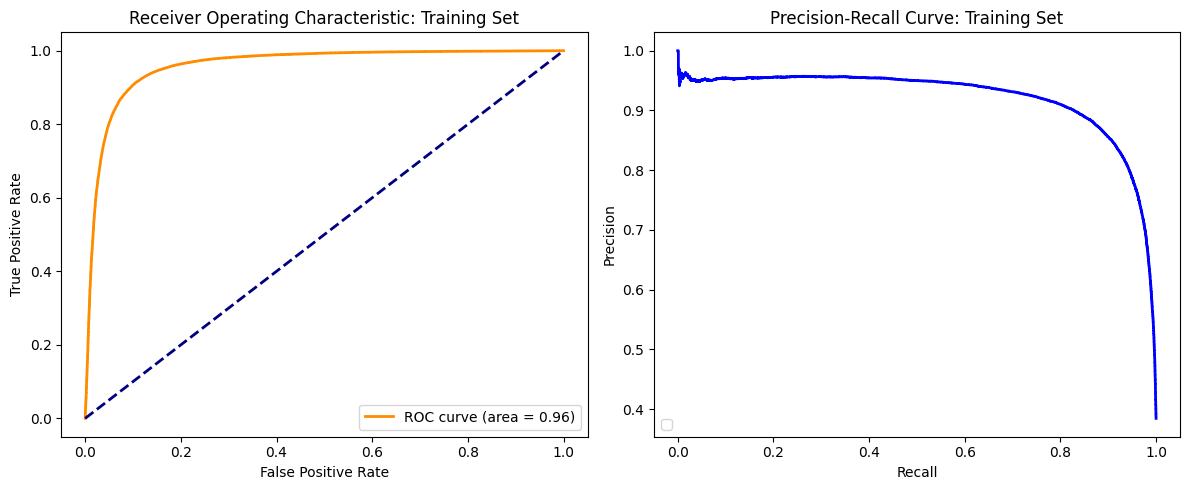

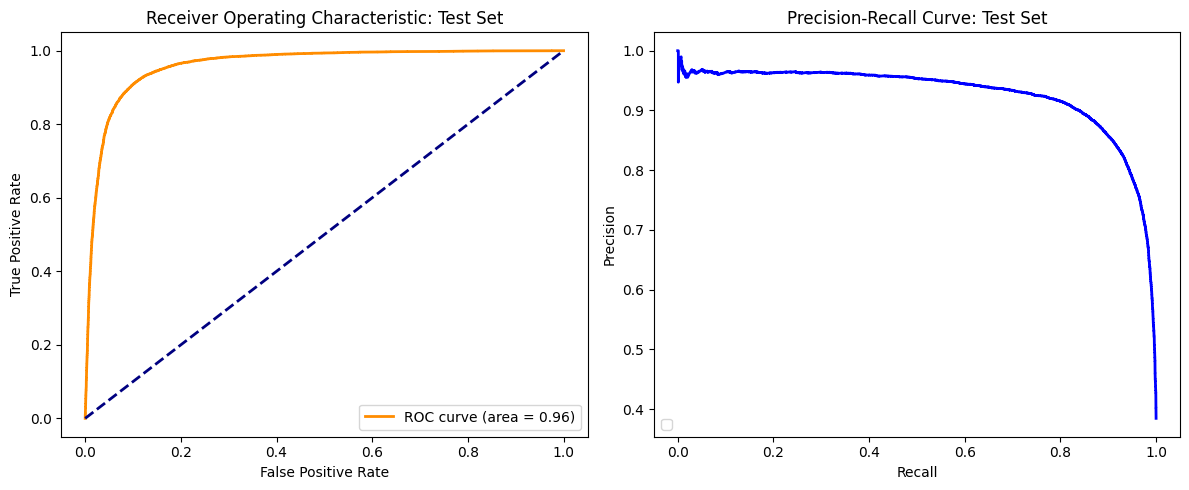

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize

# Function to plot ROC Curve and Precision-Recall Curve
def plot_roc_pr_curves(y_true, y_scores, title_suffix=''):
    # Calculate ROC Curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(12, 5))

    # Plot ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic' + title_suffix)
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve' + title_suffix)
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Assuming your logistic regression model outputs probabilities for the positive class
y_train_scores = lr.predict_proba(train_vec)[:, 1]
y_test_scores = lr.predict_proba(test_vec)[:, 1]

plot_roc_pr_curves(train_labels_new, y_train_scores, title_suffix=': Training Set')
plot_roc_pr_curves(test_labels_new, y_test_scores, title_suffix=': Test Set')

In [18]:
average_method = 'weighted'  # Example for multiclass with label imbalance

overall_precision = precision_score(test_labels_new, y_test_pred, average=average_method)
overall_recall = recall_score(test_labels_new, y_test_pred, average=average_method)
overall_f1 = f1_score(test_labels_new, y_test_pred, average=average_method)

print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1}')

Overall Precision: 0.9055420626699363
Overall Recall: 0.9054912215166231
Overall F1 Score: 0.9055155746700528
